<a href="https://colab.research.google.com/github/Asklepiad/Transcriptomics_and_sc/blob/seminar2/Transcriptomics2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk
To: /content/EM_dataset.csv
100% 12.6k/12.6k [00:00<00:00, 40.2MB/s]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.special import logsumexp

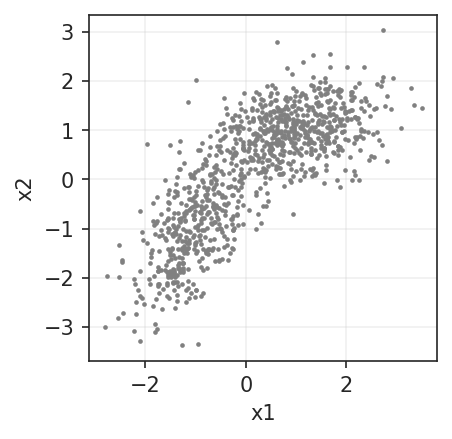

In [ ]:
sns.set_style("ticks")
df = pd.read_csv("EM_dataset.csv")
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, color="grey", linewidth=0, ax=ax)
ax.grid(alpha=0.3)

In [76]:
# Choosing the colours' gamma, number of clusters and naming the dots of dataset
colores = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]
clusters_numbers = 3
X = df.values

In [77]:
# 2D Normal distributions dispersion
def get_random_psd(n=2):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())

# Creating initial parameters for n clusters (up to 8)
def create_params(clusters_number):
    params = {}
    for cn in range(clusters_number):
        params[f"phi{cn + 1}"] = 1 / clusters_number
        params[f"mu{cn + 1}"] = np.random.normal(0, 1, size=2)
        params[f"sigma{cn + 1}"] = get_random_psd()
    return params

In [78]:
# Initialising starting parameters for 3 clusters

params = create_params(clusters_numbers)
print(params)

{'phi1': 0.3333333333333333, 'mu1': array([-0.06676329, -1.38633557]), 'sigma1': array([[4.54962249, 4.86443002],
       [4.86443002, 5.49805945]]), 'phi2': 0.3333333333333333, 'mu2': array([-0.20968979,  0.51530116]), 'sigma2': array([[0.96689325, 1.00900215],
       [1.00900215, 1.09556451]]), 'phi3': 0.3333333333333333, 'mu3': array([-1.57255098,  0.1236906 ]), 'sigma3': array([[4.4201215 , 0.44083649],
       [0.44083649, 3.22975607]])}


In [79]:
params

{'phi1': 0.3333333333333333,
 'mu1': array([-0.06676329, -1.38633557]),
 'sigma1': array([[4.54962249, 4.86443002],
        [4.86443002, 5.49805945]]),
 'phi2': 0.3333333333333333,
 'mu2': array([-0.20968979,  0.51530116]),
 'sigma2': array([[0.96689325, 1.00900215],
        [1.00900215, 1.09556451]]),
 'phi3': 0.3333333333333333,
 'mu3': array([-1.57255098,  0.1236906 ]),
 'sigma3': array([[4.4201215 , 0.44083649],
        [0.44083649, 3.22975607]])}

## Custom version (for multivariant)

In [91]:
# Visualise distributions (without painting the dots)
def paint_distributions(clusters_numbers, params):
    hists = {}
    fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
    sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, color="grey")
    ax.grid(alpha=0.3)
    for cn in range(clusters_numbers):
        hists[f"hist{cn + 1}"] = stats.multivariate_normal(params[f"mu{cn + 1}"], params[f"sigma{cn + 1}"]).rvs(size=1000)
        sns.kdeplot(x=hists[f"hist{cn + 1}"][:, 0], y=hists[f"hist{cn + 1}"][:, 1], ax=ax, color=colores[cn], fill=True, alpha=0.5)

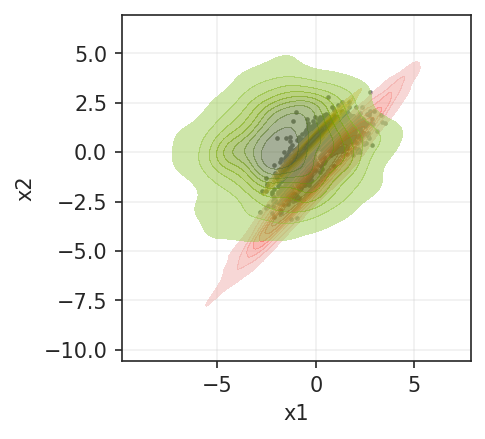

In [92]:
paint_distributions(clusters_numbers, params)

In [96]:
def E_step(X, params, clusters_numbers, draw=False):
    LogLikelihood = A = np.log([
        stats.multivariate_normal(params[f"mu{cn + 1}"], params[f"sigma{cn + 1}"]).pdf(X) for cn in range(clusters_numbers)
    ])

    logPrior = B = np.log([
        params[f"phi{clusters_numbers - cn}"] for cn in range(clusters_numbers)
    ])

    logPosterior = D = logPrior + LogLikelihood.T
    RealSoftMax = C = logsumexp(logPosterior, axis=1)
    probabilities = np.exp(logPosterior - np.array([RealSoftMax]).T)
    #print(f"A:{A}, B:{B}, C:{C}, D:{D}")
    if draw:
        paint_distributions(clusters_numbers, params)

    return RealSoftMax, probabilities

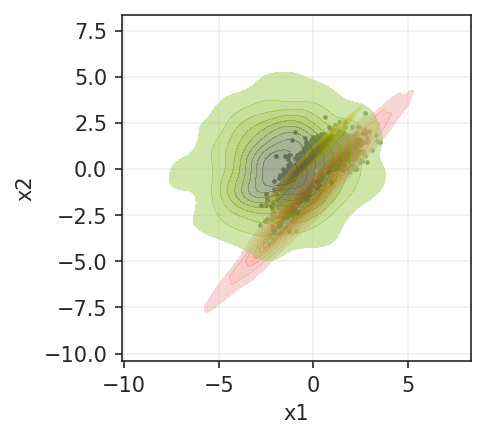

In [82]:
total_prob, probabilities = E_step(X, params, clusters_numbers, draw=True)

In [83]:
def M_step(X, params, probabilities, clusters_numbers):
    probs = {}
    params = {}
    for cn in range(clusters_numbers):
        probs[f"prob_{cn + 1}"] = probabilities[:, cn]

    for cn in range(clusters_numbers):
        cur_prob = probs[f"prob_{cn +1}"]
        params[f"phi{cn + 1}"] = cur_prob.sum() / len(X)
        params[f"mu{cn + 1}"] = cur_prob.dot(X) / np.sum(cur_prob)
        params[f"sigma{cn + 1}"] = (X - params[f"mu{cn + 1}"]).T.dot((X - params[f"mu{cn + 1}"]) * np.array([cur_prob]).T) / np.sum(cur_prob)
    return params

In [97]:
def run_EM(X, params, clusters_numbers, draw=False):
    import imageio
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params, clusters_numbers, draw=draw)
        avg_allprob.append(np.mean(allprob))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.00001:
            break
        params = M_step(X, params, probabilities, clusters_numbers)
        print(f"\nparams:{params}")

    loglikelihood, probabilities = E_step(X, params, clusters_numbers)
    forecasts = np.argmax(probabilities, axis=1)
    return forecasts, probabilities, avg_allprob, params


params:{'phi1': 0.3358247538286102, 'mu1': array([0.72415923, 0.01894036]), 'sigma1': array([[1.89535259, 1.7461423 ],
       [1.7461423 , 1.84556051]]), 'phi2': 0.2994503863002655, 'mu2': array([-0.17188589,  0.46971185]), 'sigma2': array([[0.84105034, 0.83671115],
       [0.83671115, 0.91901744]]), 'phi3': 0.3647248598711243, 'mu3': array([-0.12359536,  0.03429699]), 'sigma3': array([[1.41516546, 1.14440229],
       [1.14440229, 1.50756373]])}

params:{'phi1': 0.36500830216360214, 'mu1': array([ 0.62454961, -0.00233406]), 'sigma1': array([[1.95883726, 1.71894209],
       [1.71894209, 1.75864709]]), 'phi2': 0.262175055753378, 'mu2': array([-0.13499934,  0.48542163]), 'sigma2': array([[0.83809486, 0.80466751],
       [0.80466751, 0.89179232]]), 'phi3': 0.3728166420830198, 'mu3': array([-0.12320087,  0.08881446]), 'sigma3': array([[1.36125982, 1.1175117 ],
       [1.1175117 , 1.53158759]])}

params:{'phi1': 0.3769933676487237, 'mu1': array([ 0.5735953 , -0.01686805]), 'sigma1': array([

<ipython-input-91-a62317d253eb>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(3, 3), dpi=150)



params:{'phi1': 0.3110100320091915, 'mu1': array([0.70353441, 0.34755019]), 'sigma1': array([[1.4967909 , 0.82290831],
       [0.82290831, 0.74856071]]), 'phi2': 0.35711909981050166, 'mu2': array([0.85258145, 1.16253424]), 'sigma2': array([[0.54564009, 0.11159258],
       [0.11159258, 0.20620485]]), 'phi3': 0.331870868180307, 'mu3': array([-1.13489437, -1.09599791]), 'sigma3': array([[0.28229786, 0.28517295],
       [0.28517295, 0.86221088]])}

params:{'phi1': 0.3097795710920657, 'mu1': array([0.69541826, 0.36224532]), 'sigma1': array([[1.47247587, 0.79368189],
       [0.79368189, 0.7288081 ]]), 'phi2': 0.36061822717287945, 'mu2': array([0.85461427, 1.15898246]), 'sigma2': array([[0.56380266, 0.10908178],
       [0.10908178, 0.20857757]]), 'phi3': 0.3296022017350548, 'mu3': array([-1.14372674, -1.1245113 ]), 'sigma3': array([[0.27676188, 0.26968098],
       [0.26968098, 0.81499479]])}

params:{'phi1': 0.3088768552987394, 'mu1': array([0.68637857, 0.37697194]), 'sigma1': array([[1.4493

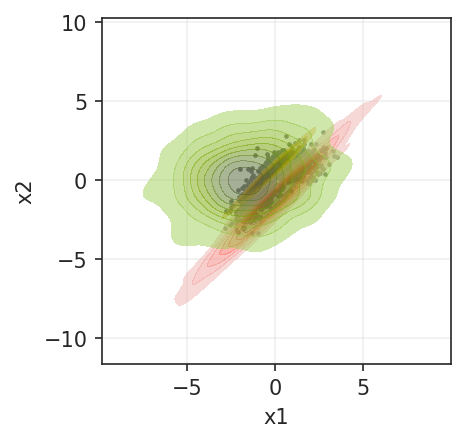

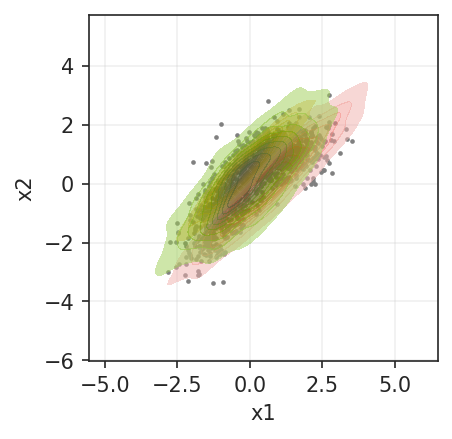

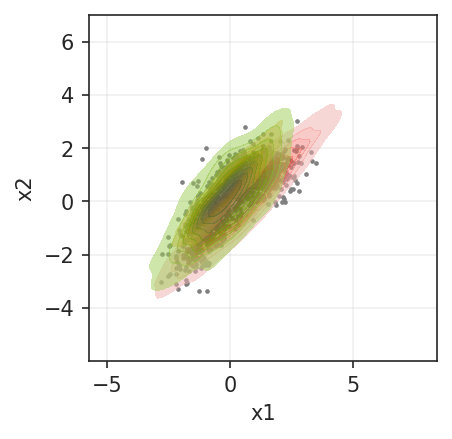

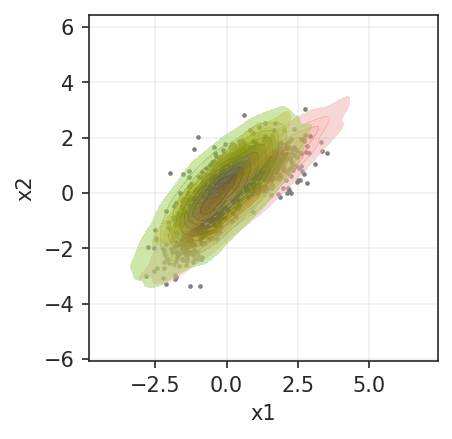

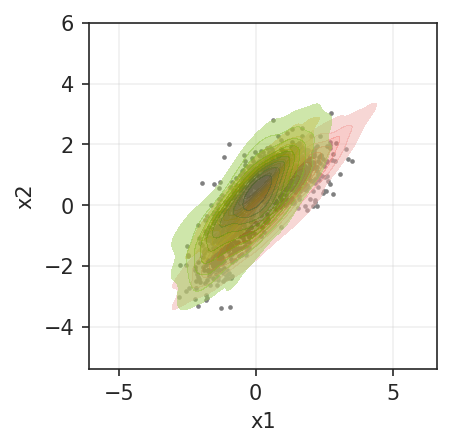

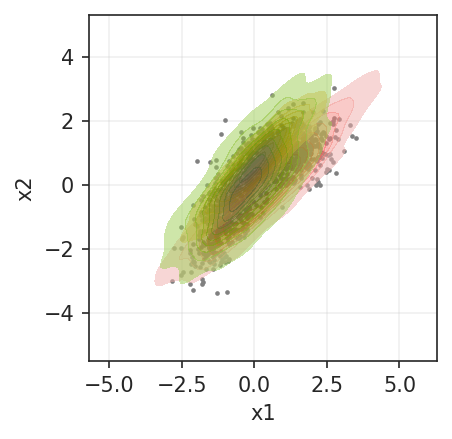

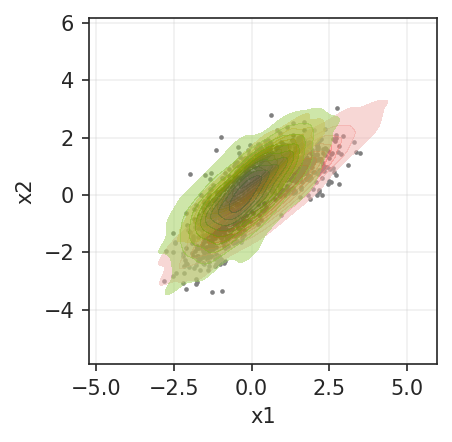

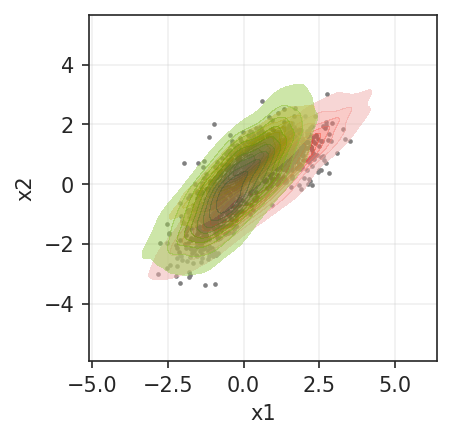

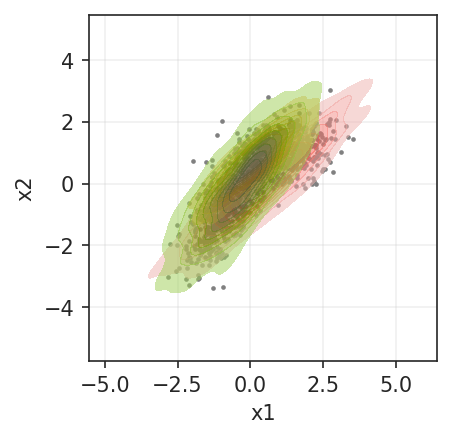

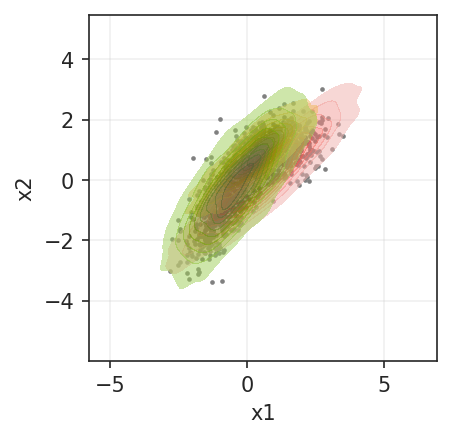

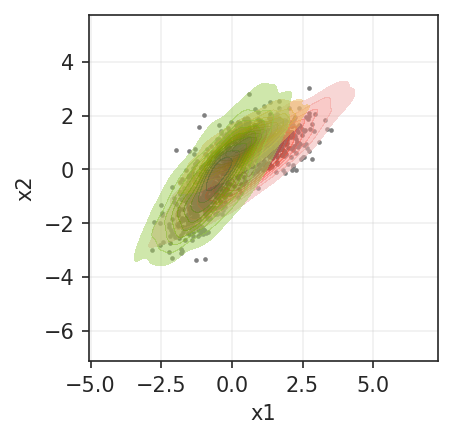

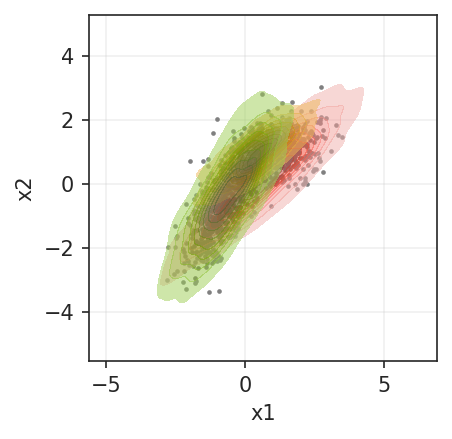

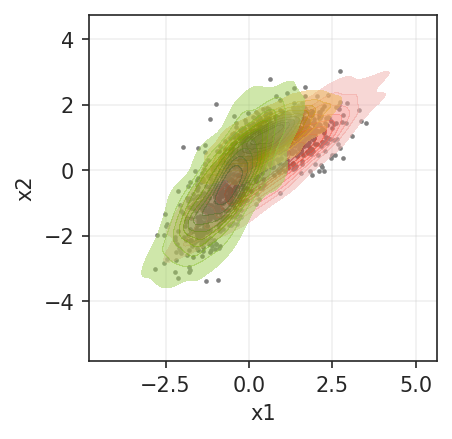

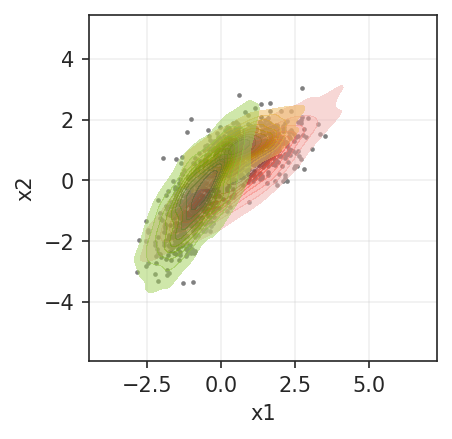

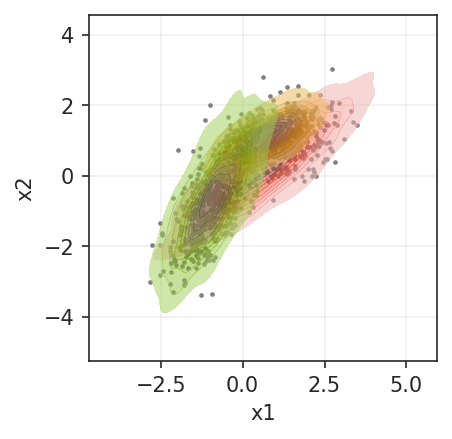

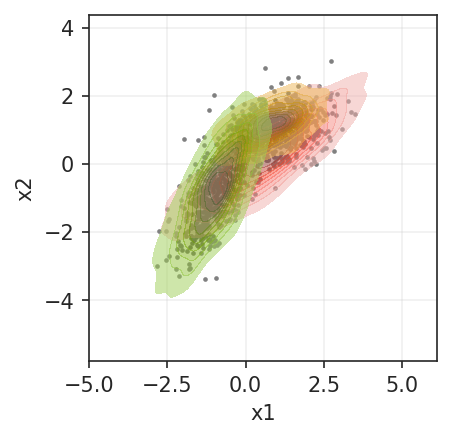

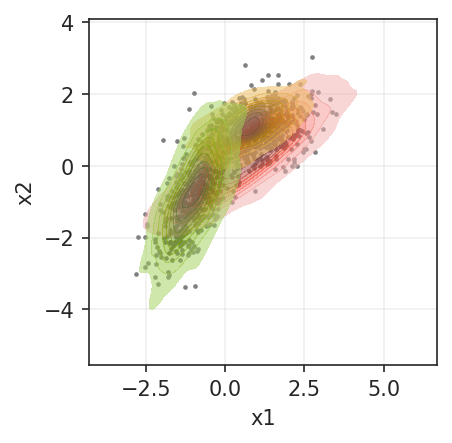

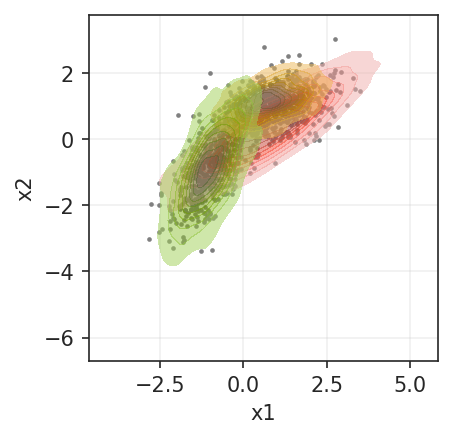

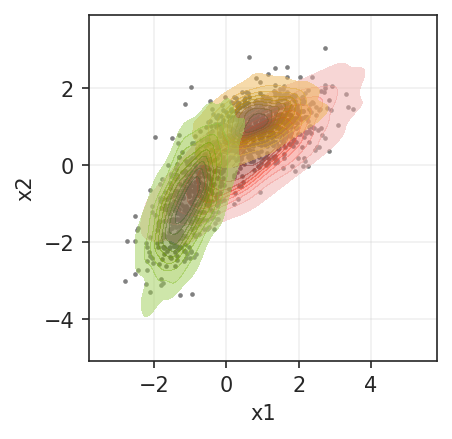

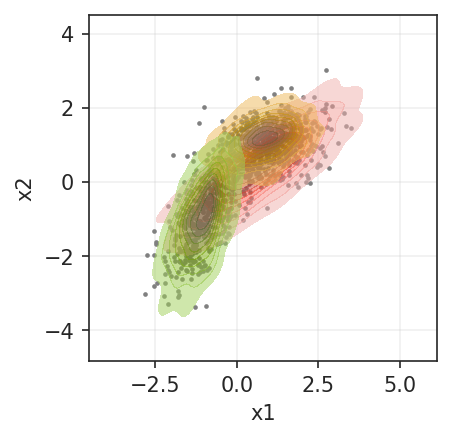

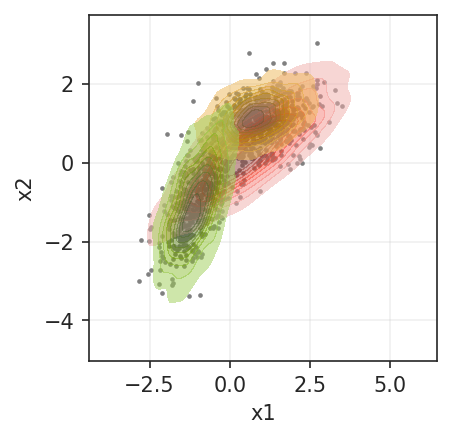

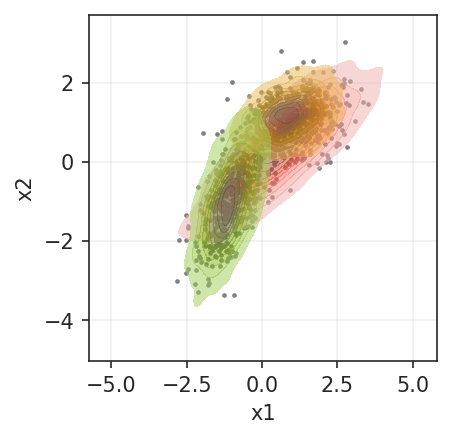

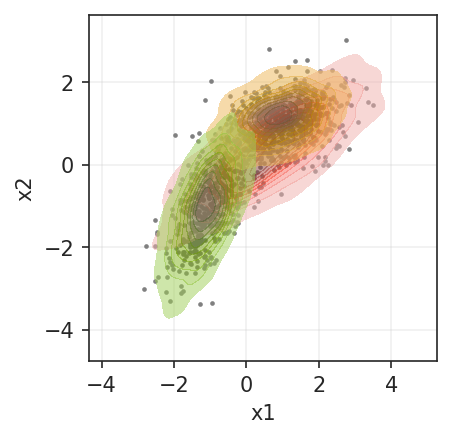

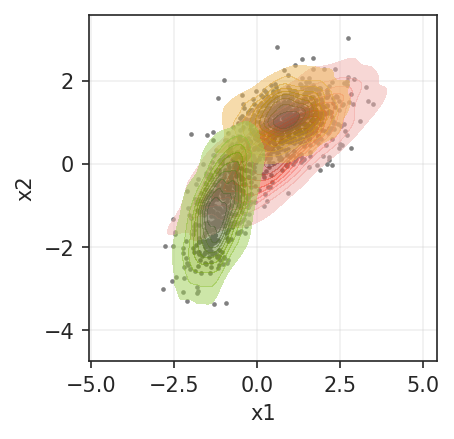

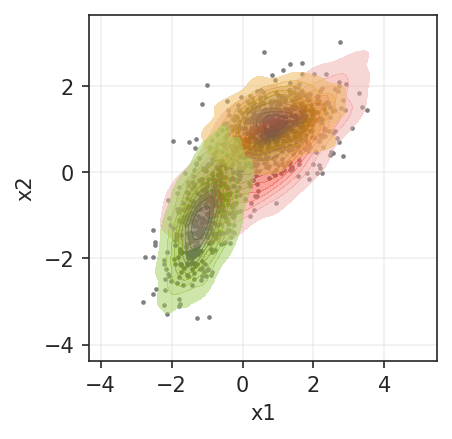

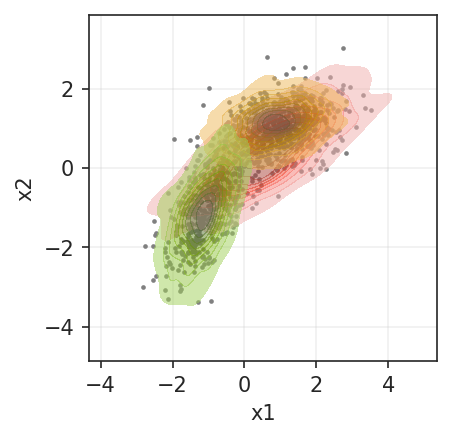

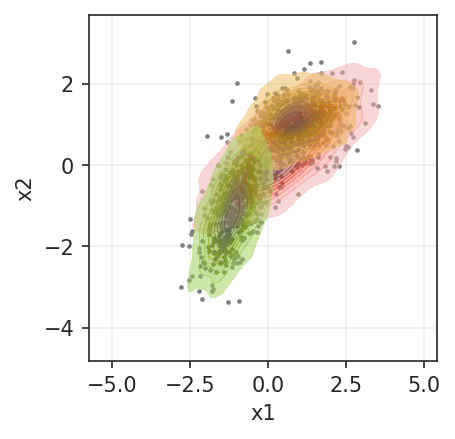

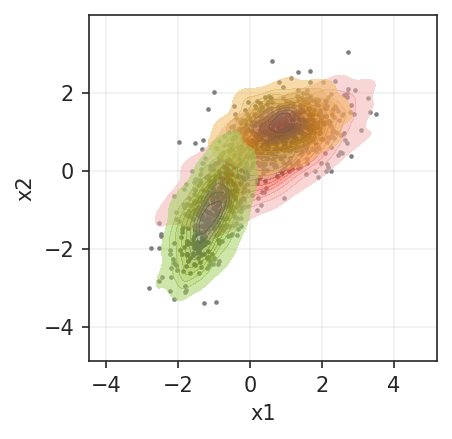

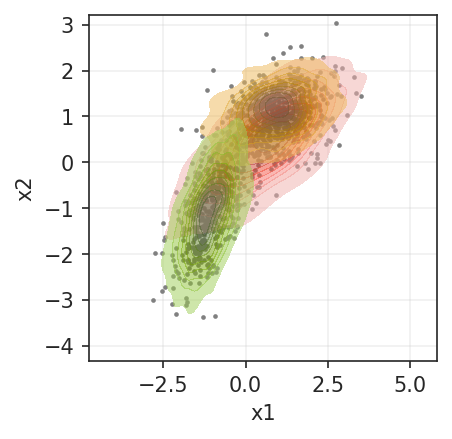

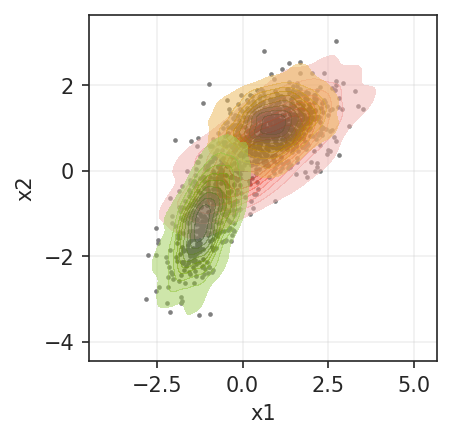

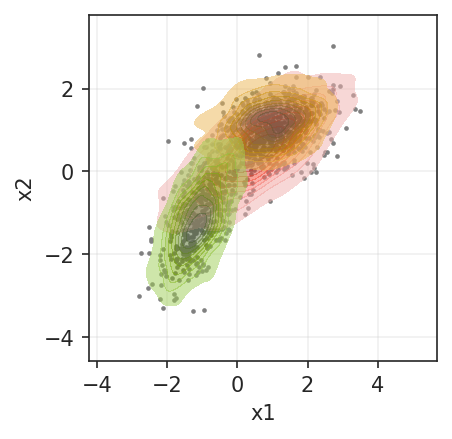

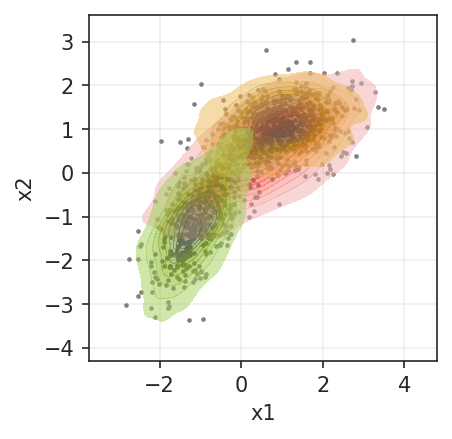

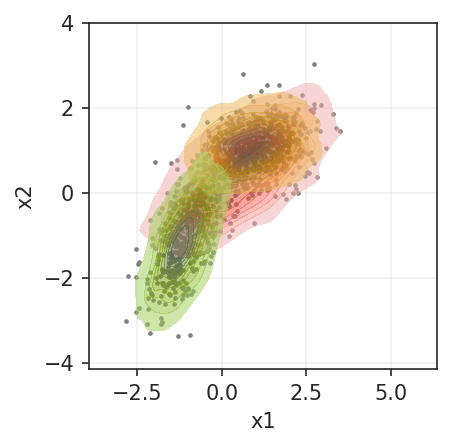

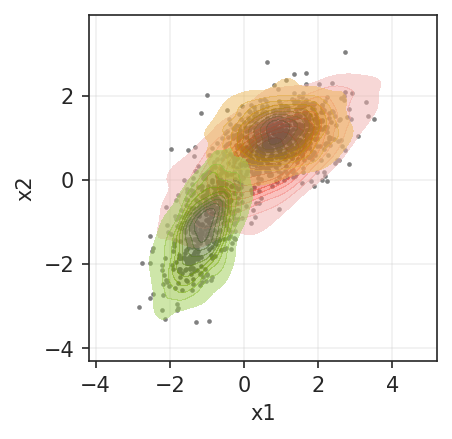

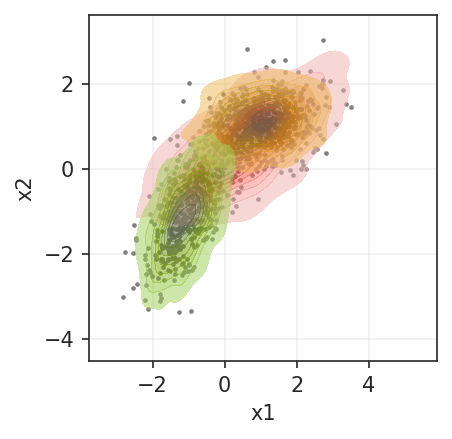

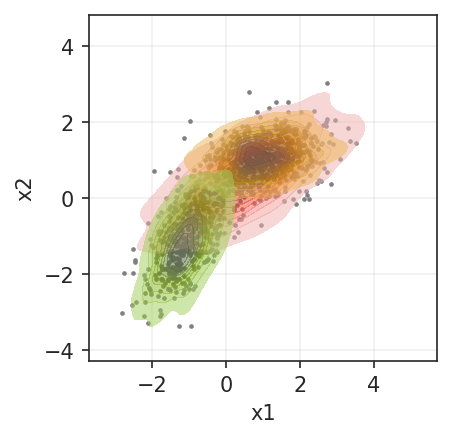

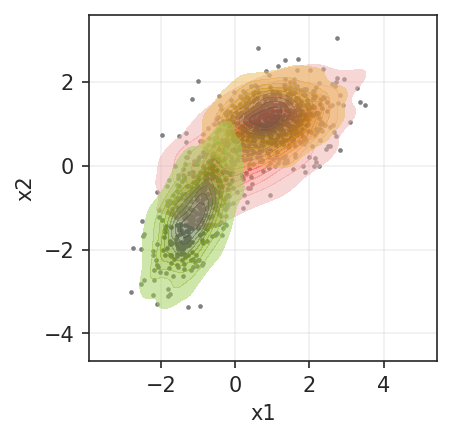

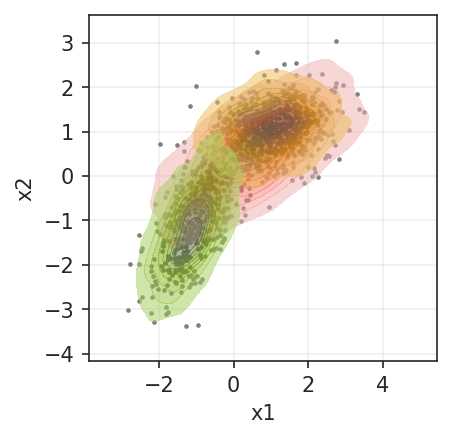

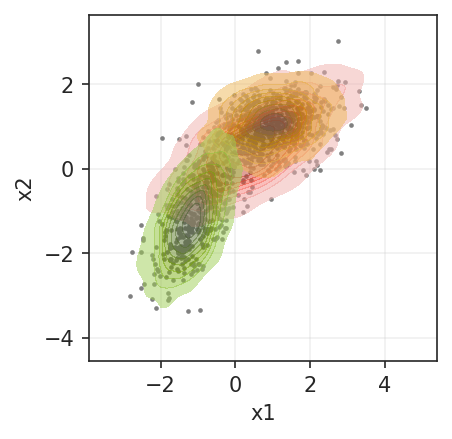

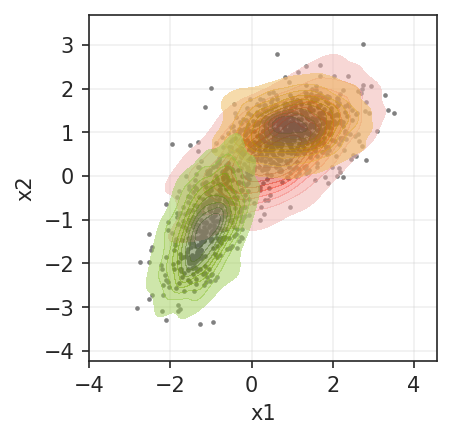

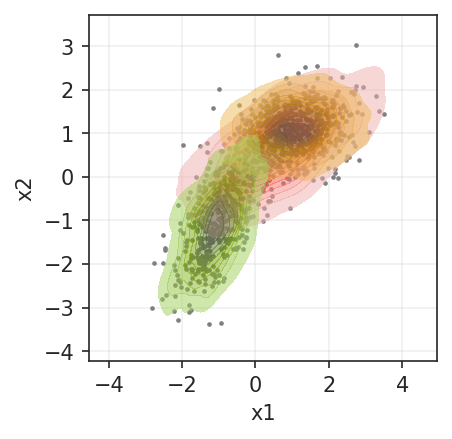

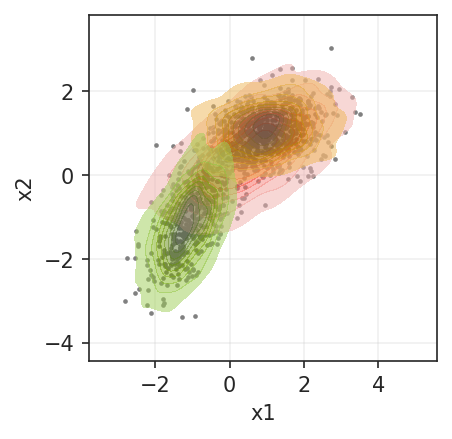

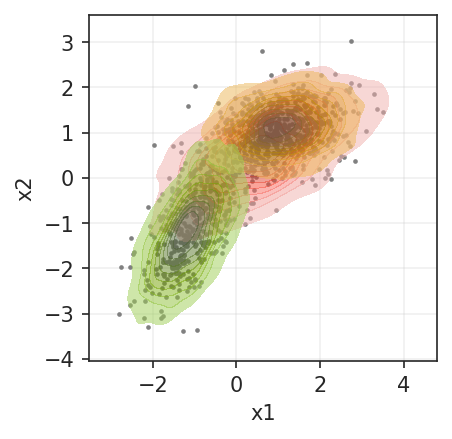

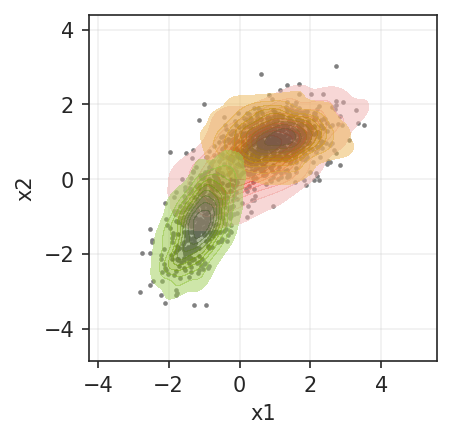

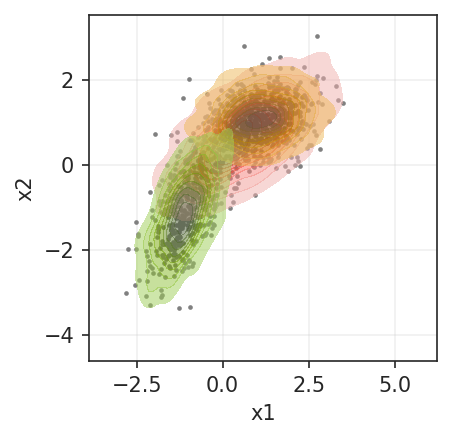

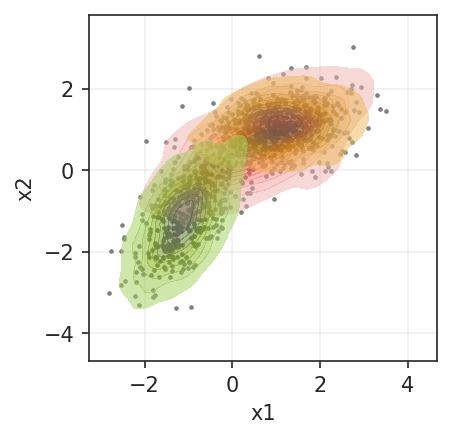

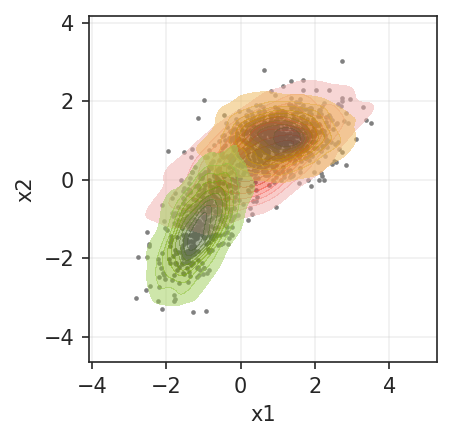

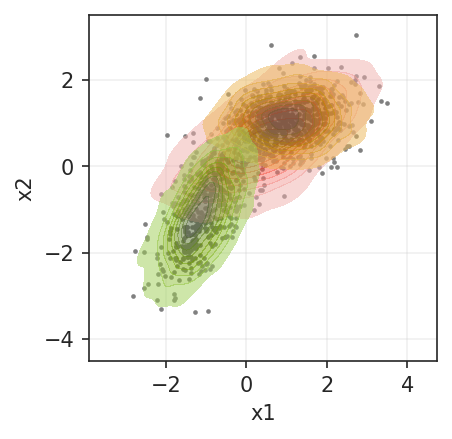

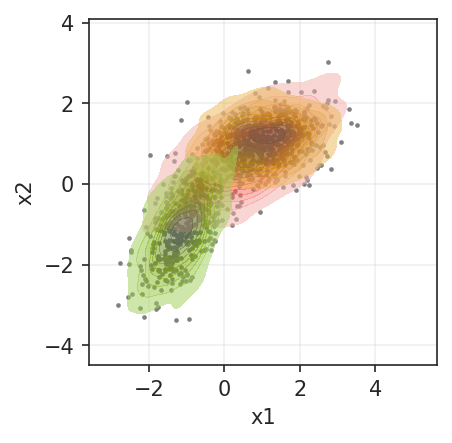

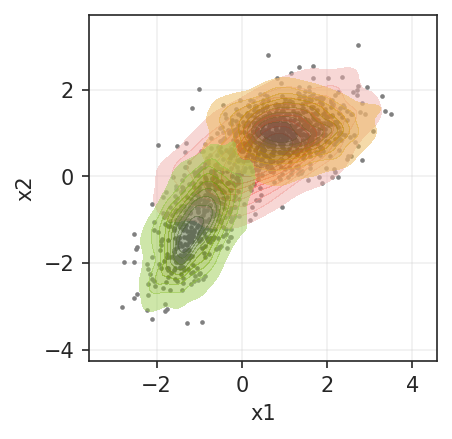

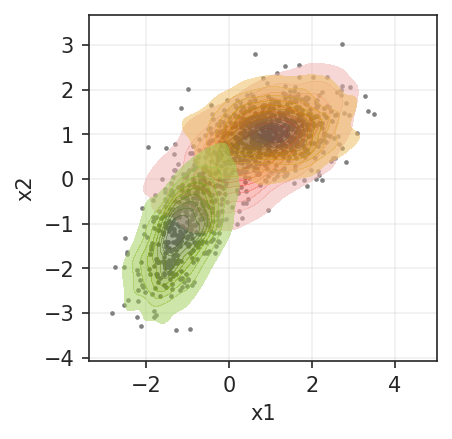

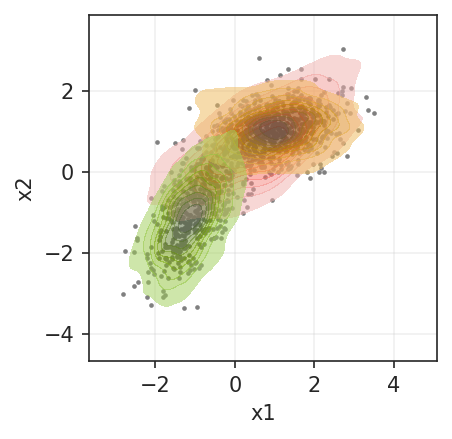

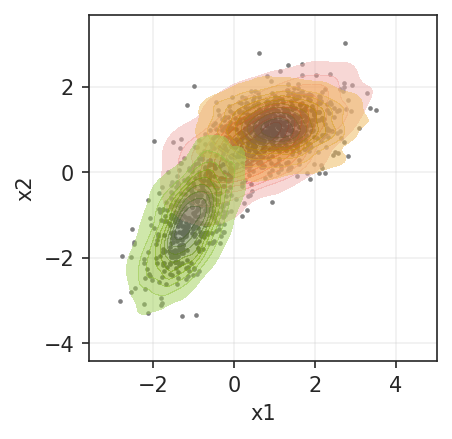

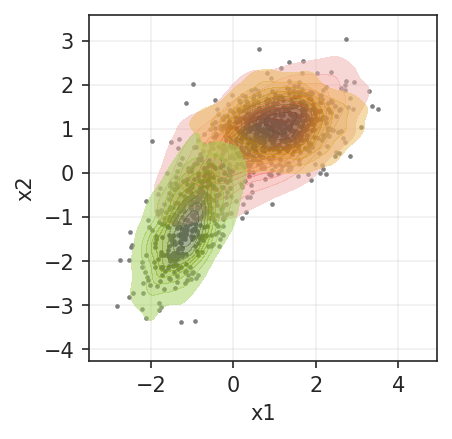

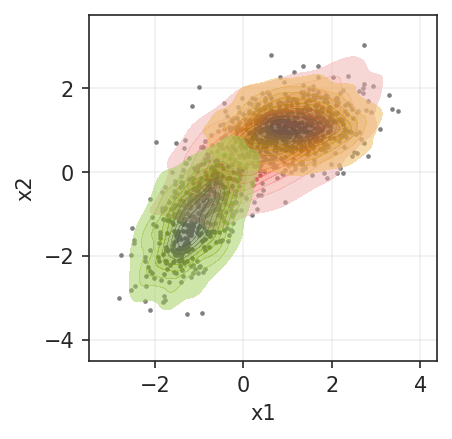

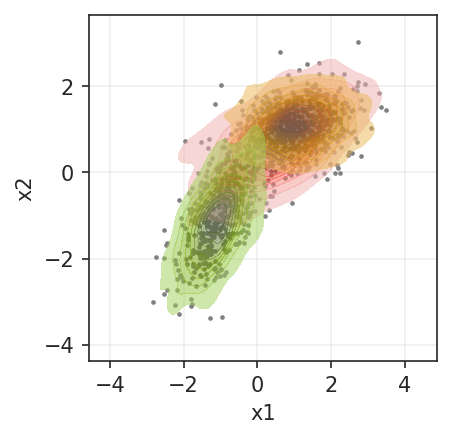

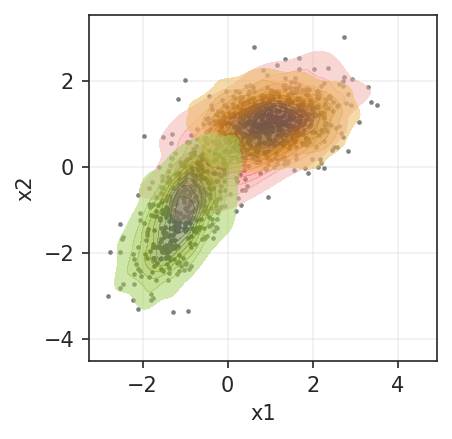

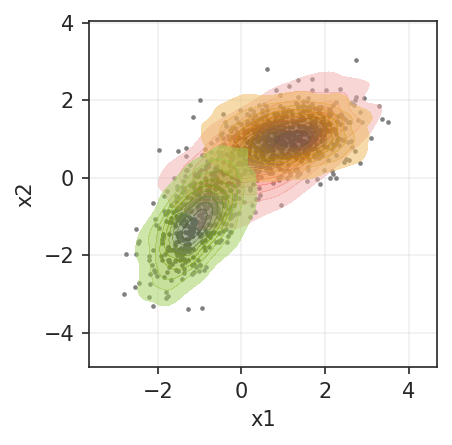

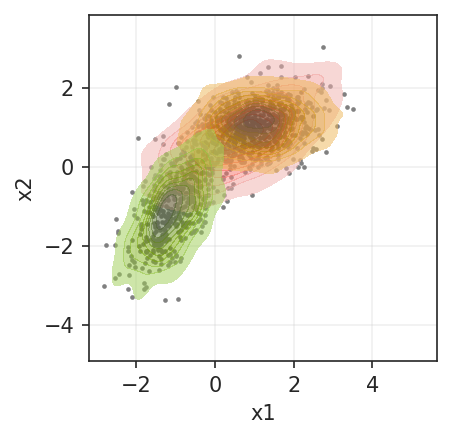

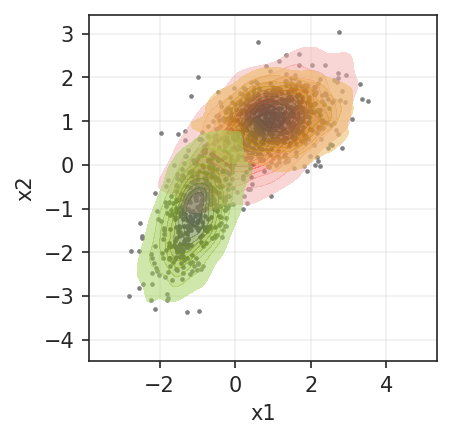

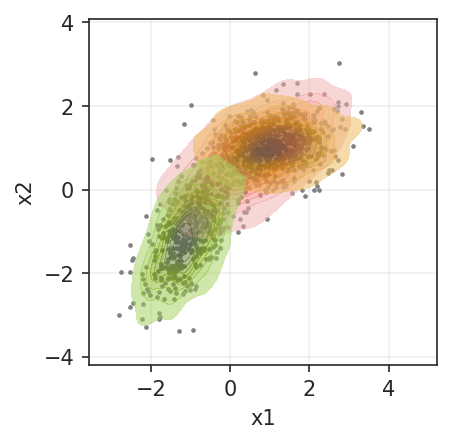

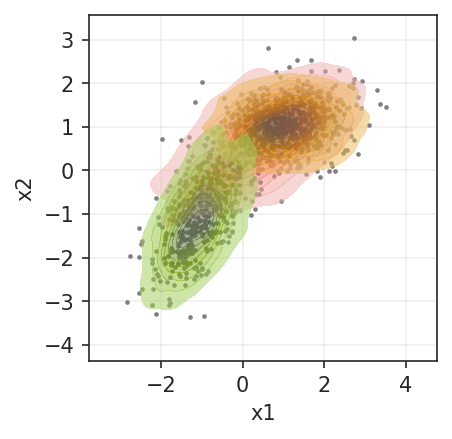

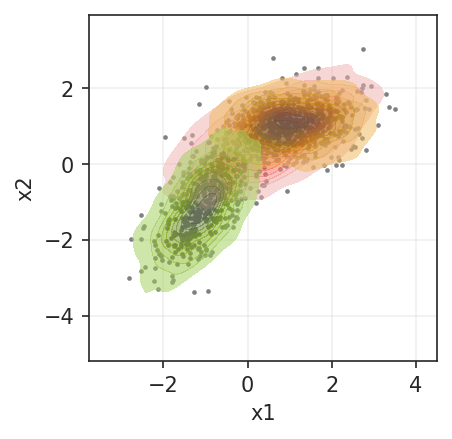

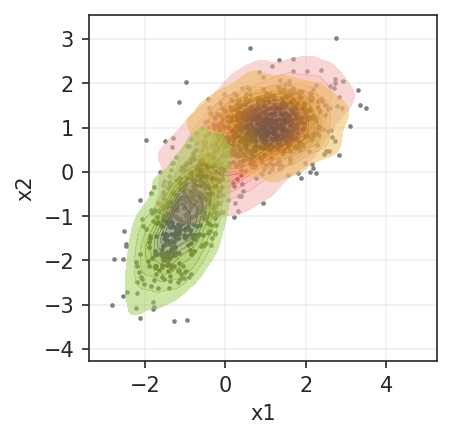

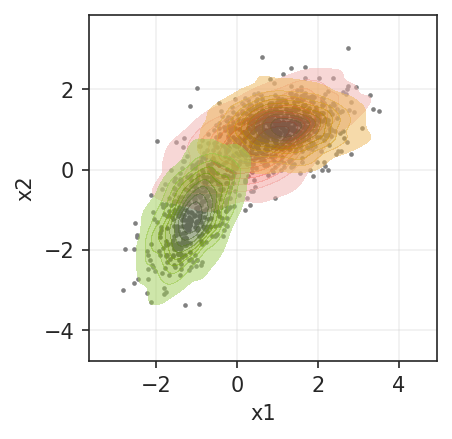

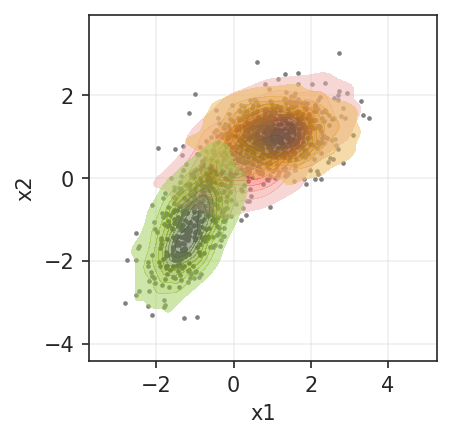

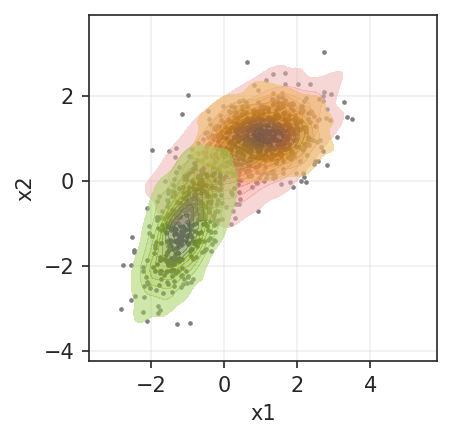

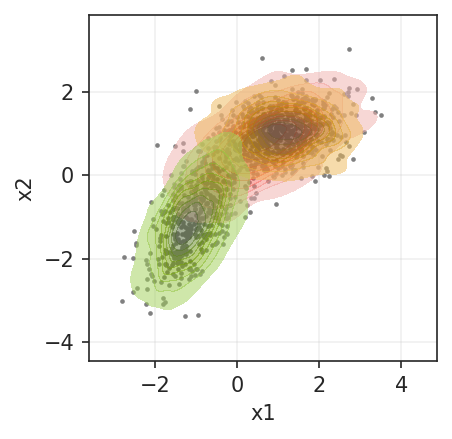

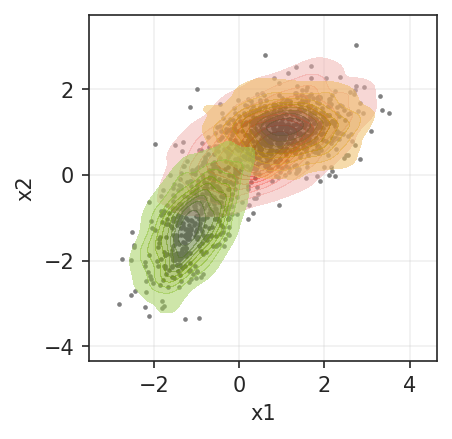

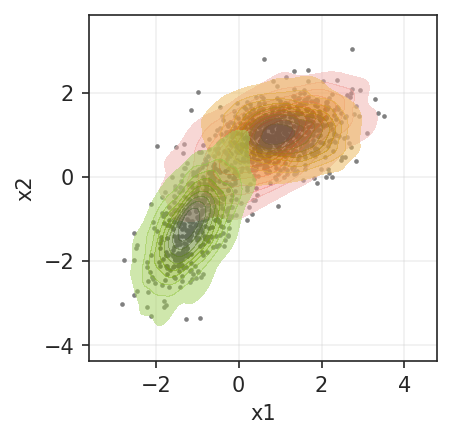

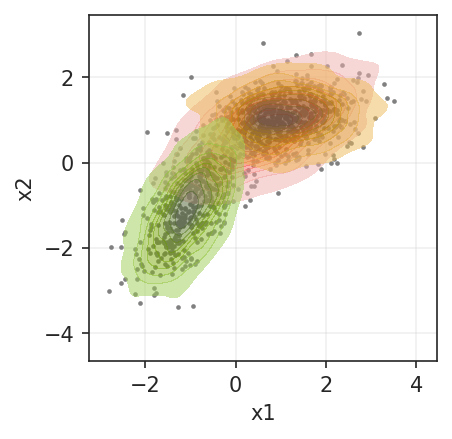

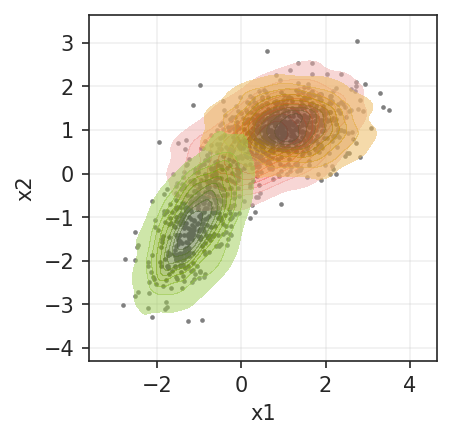

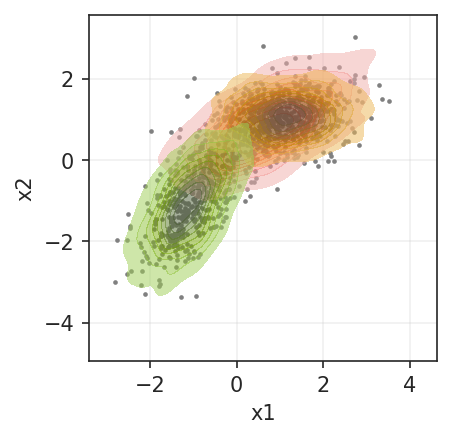

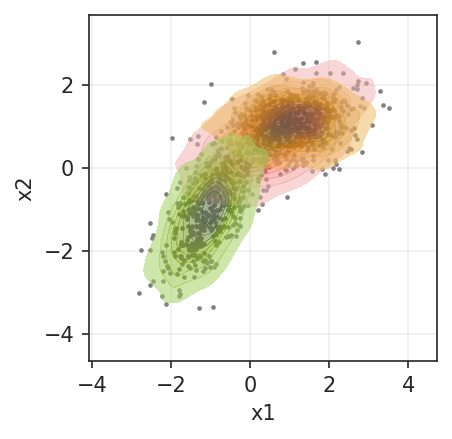

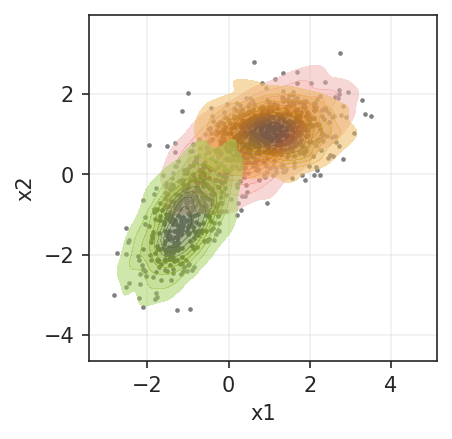

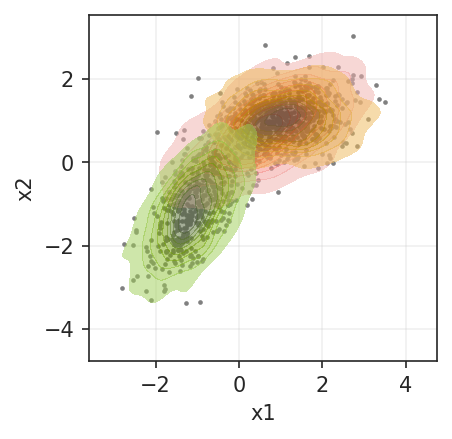

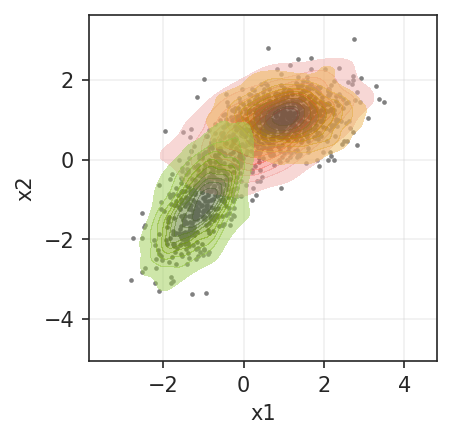

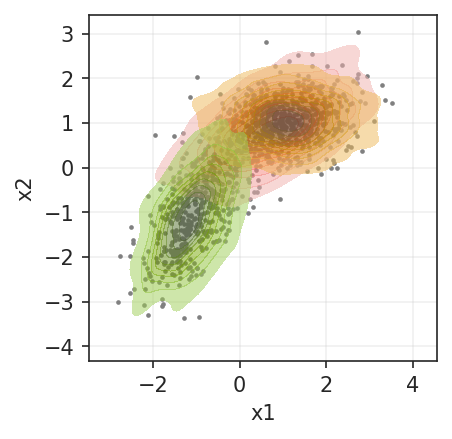

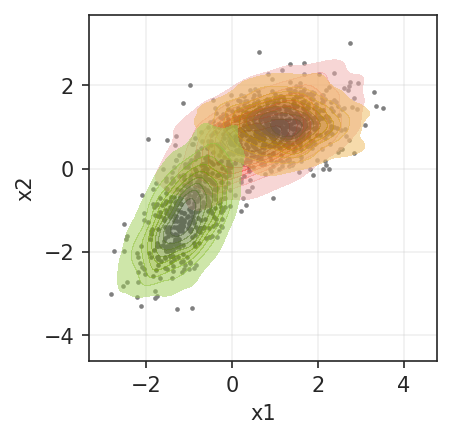

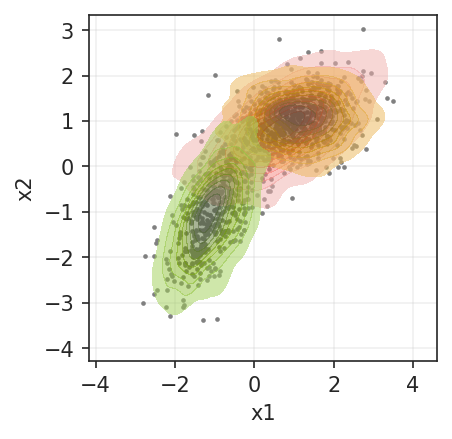

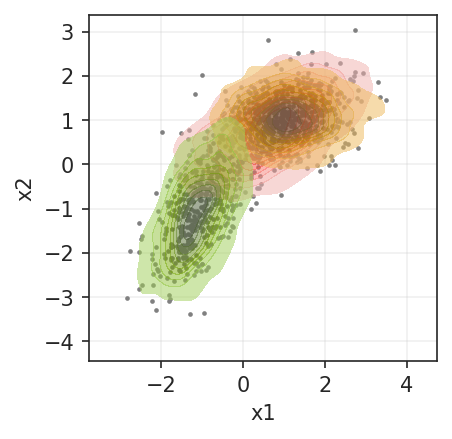

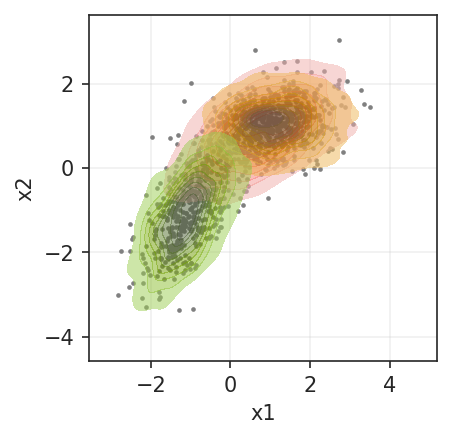

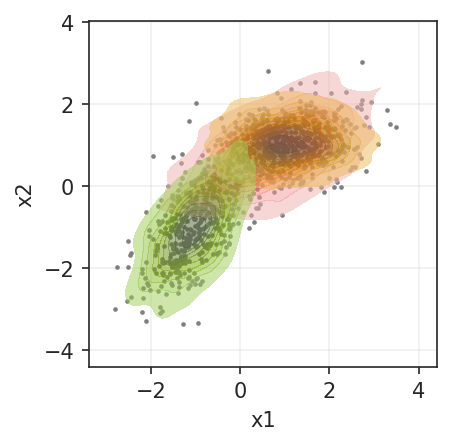

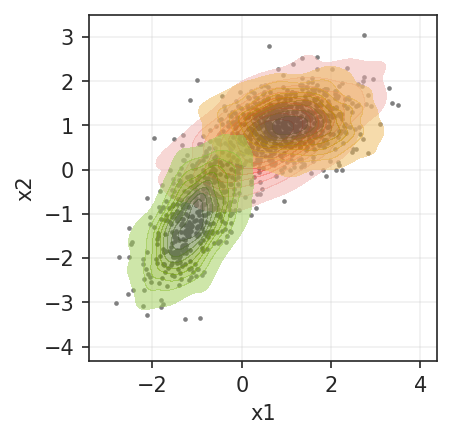

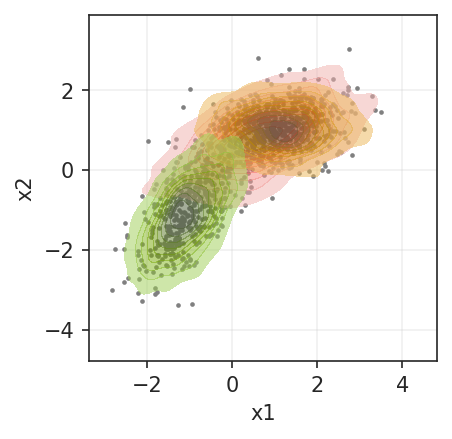

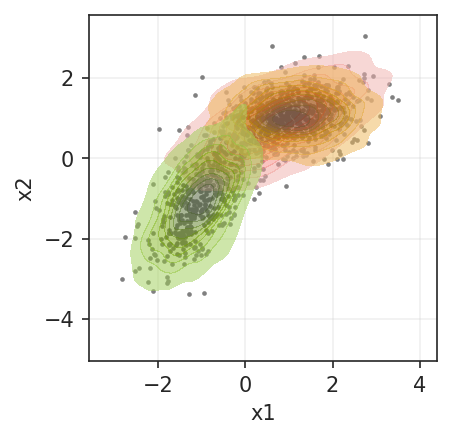

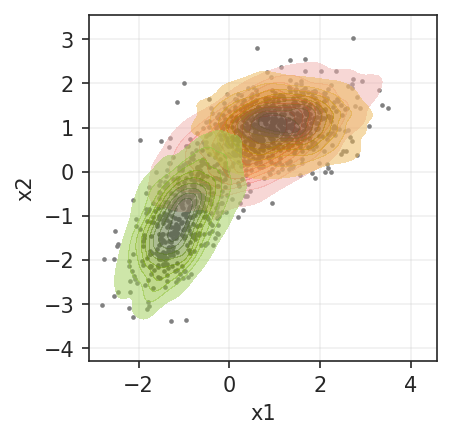

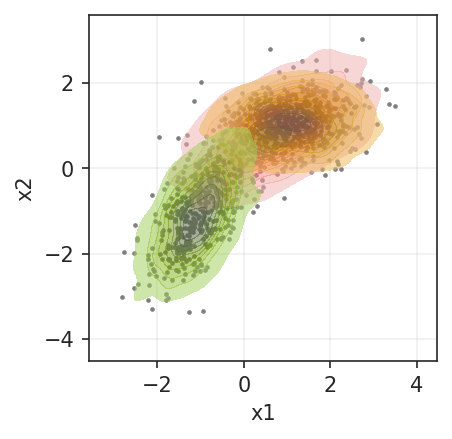

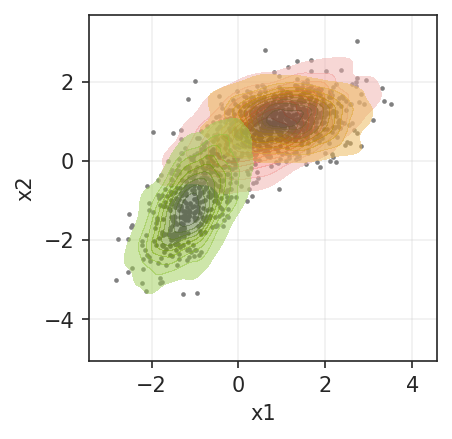

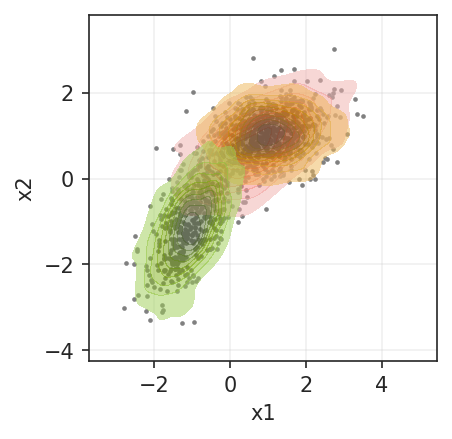

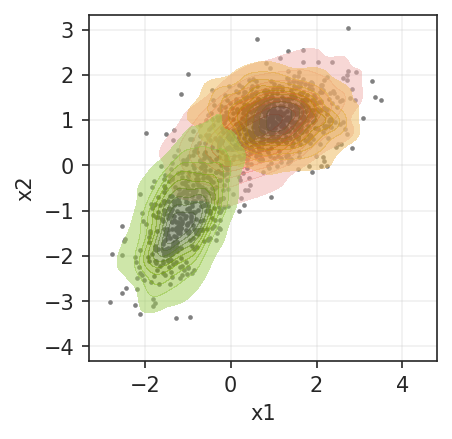

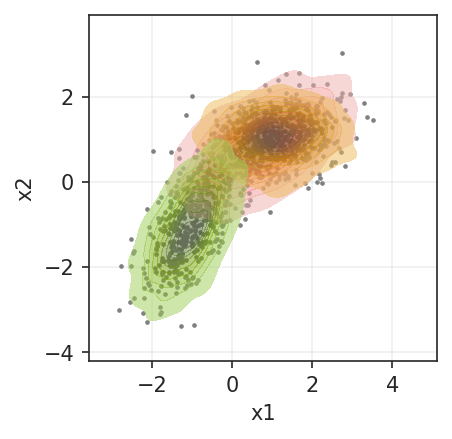

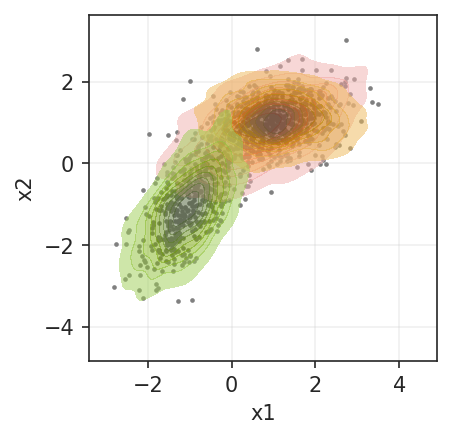

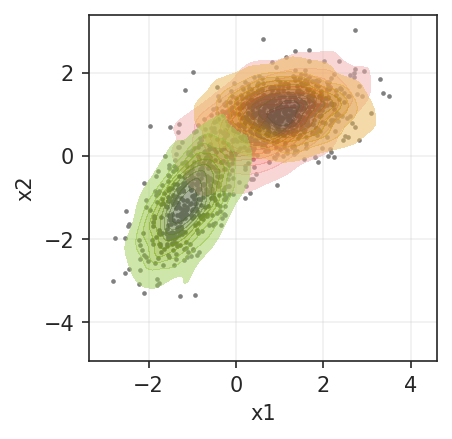

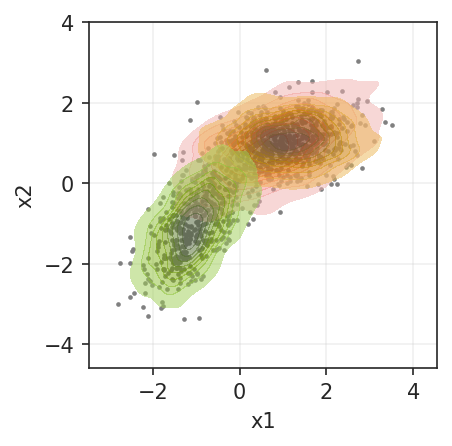

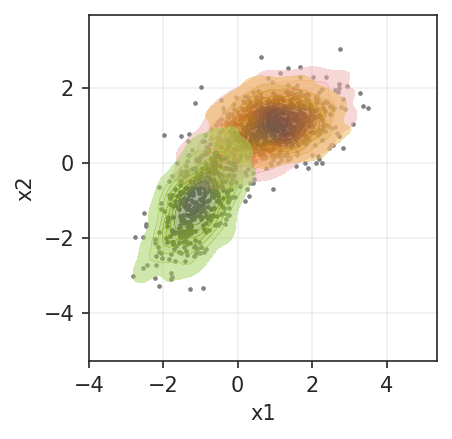

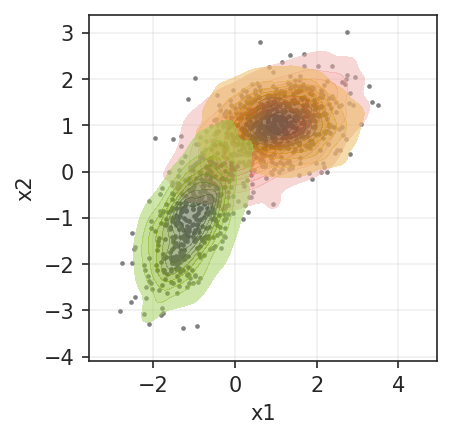

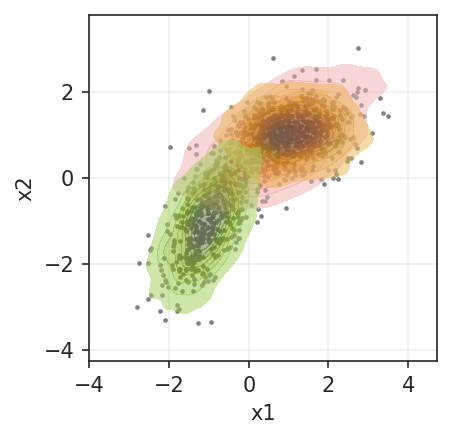

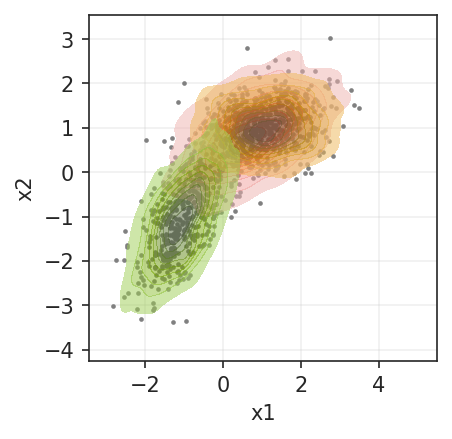

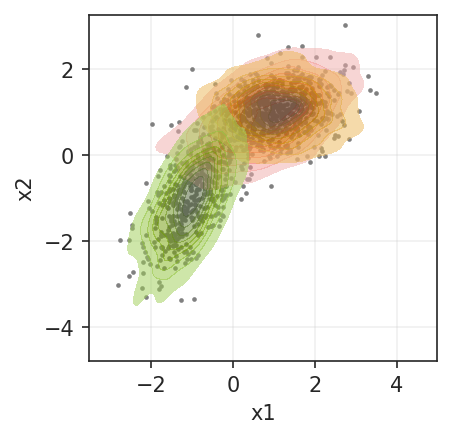

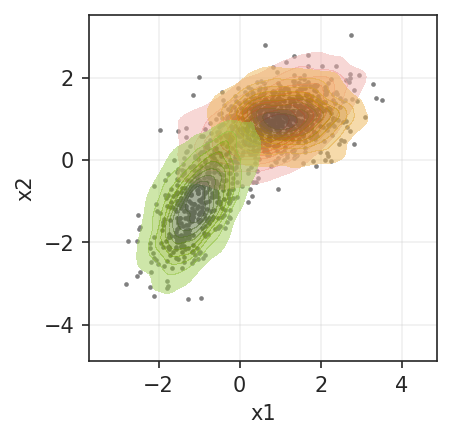

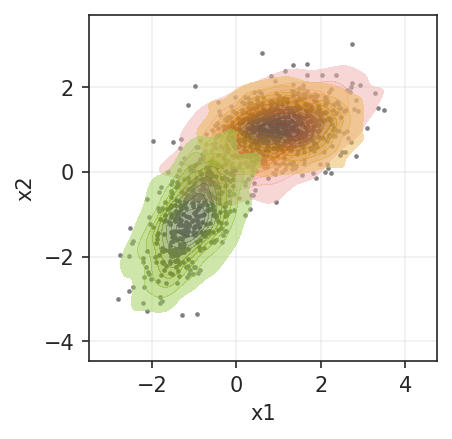

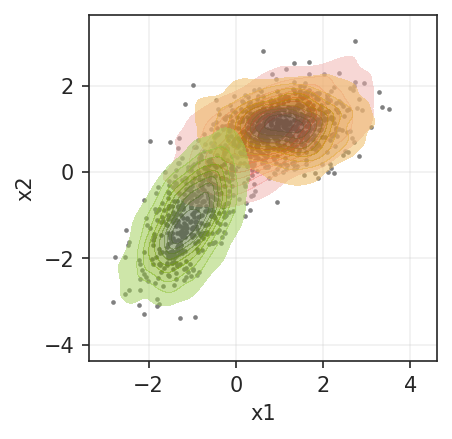

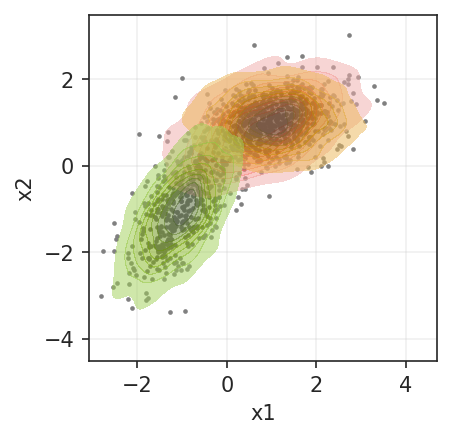

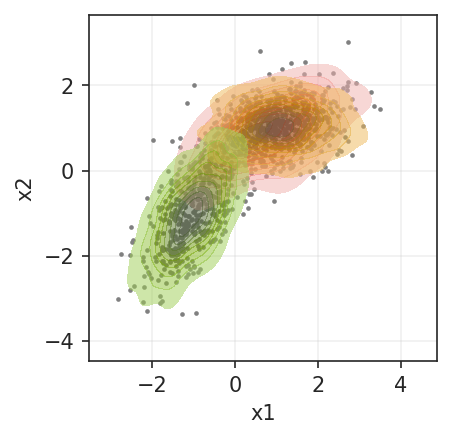

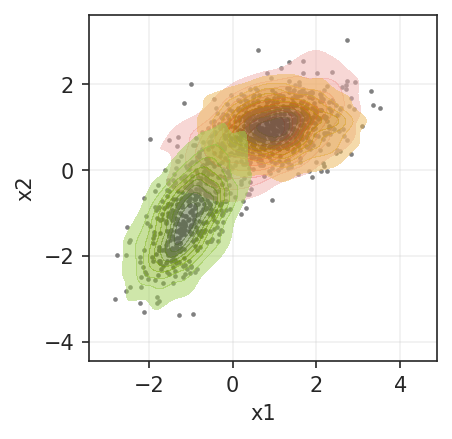

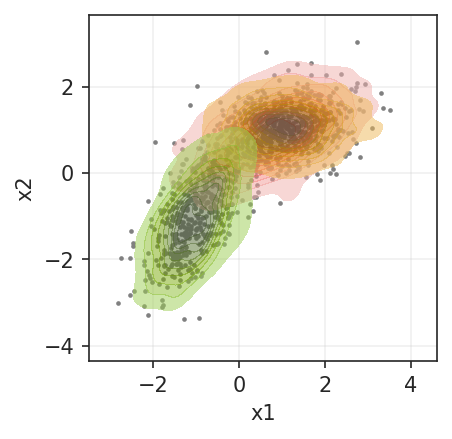

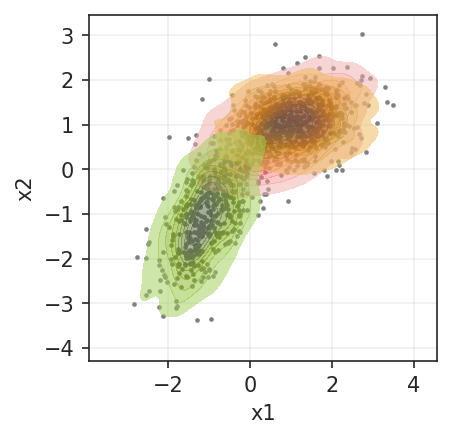

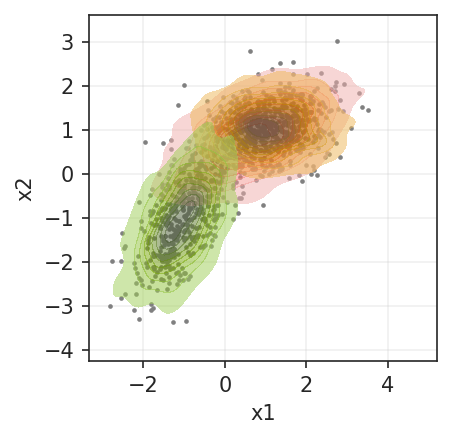

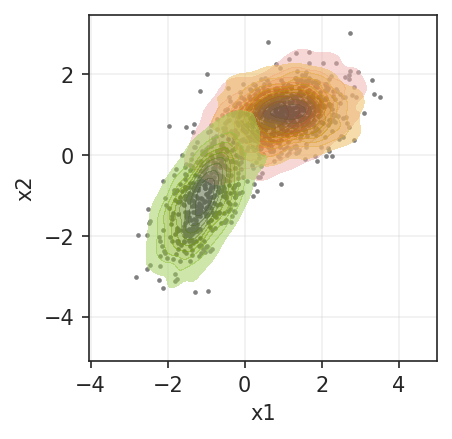

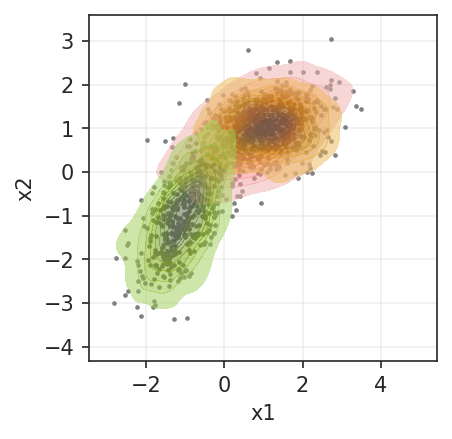

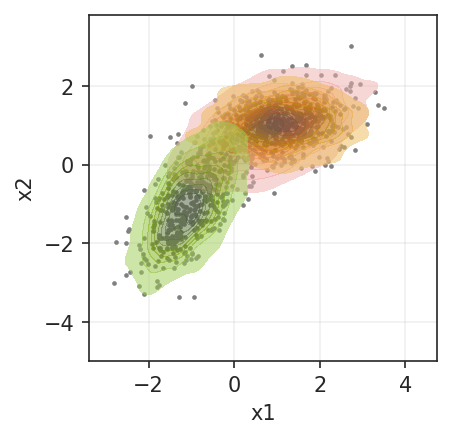

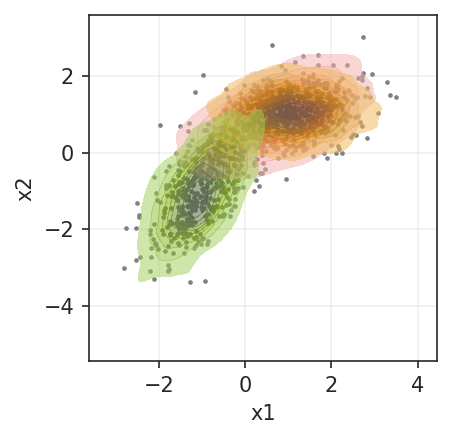

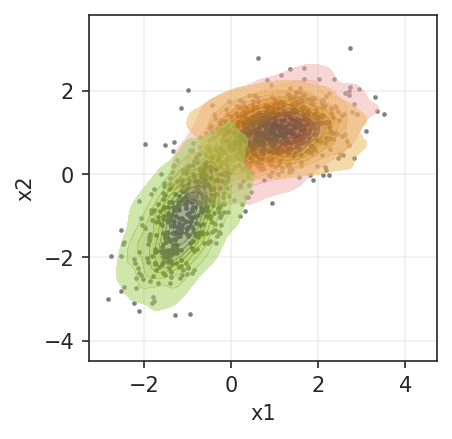

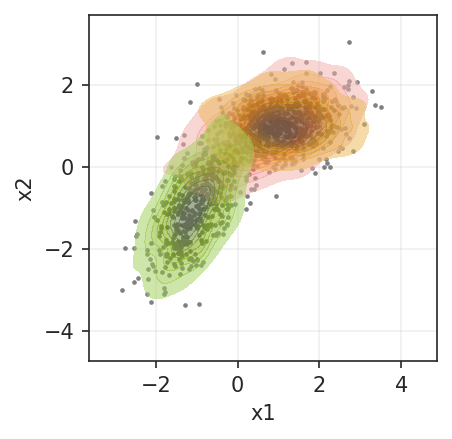

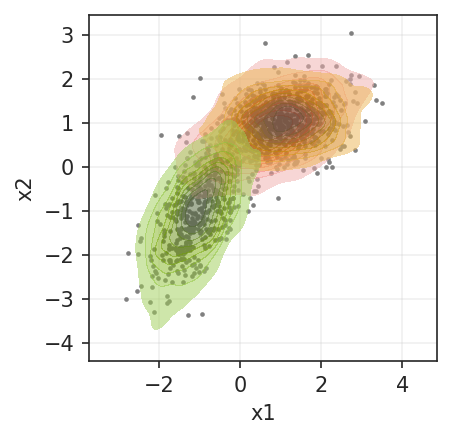

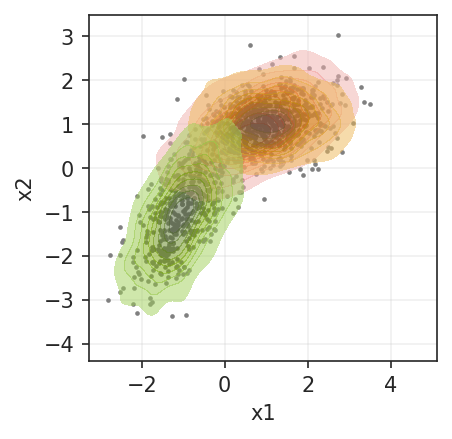

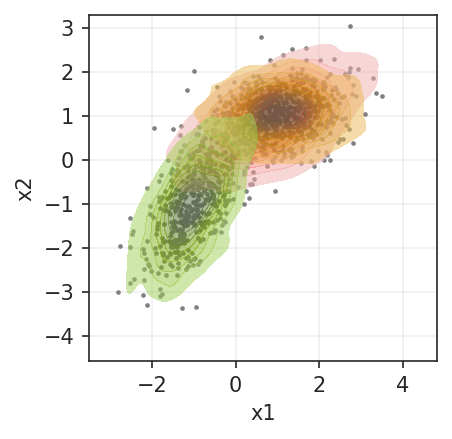

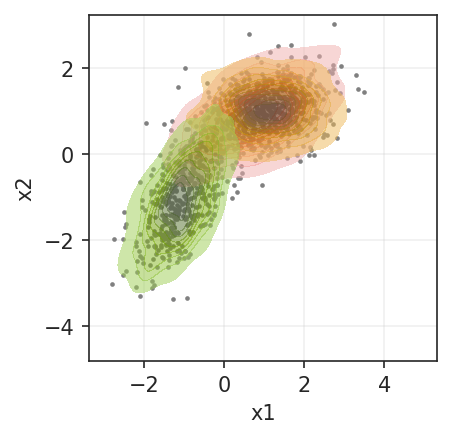

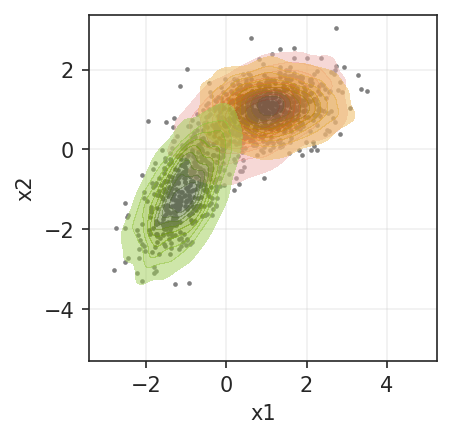

In [98]:
pred, prob, allprob, params = run_EM(X, params, clusters_numbers, draw=True)

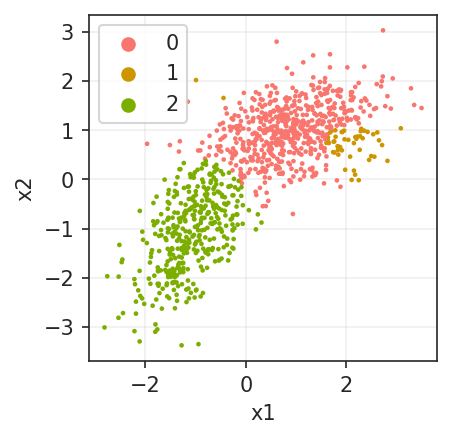

In [103]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, hue=pred,
                palette={0: colores[0],
                         1: colores[1],
                         2: colores[2]})
ax.grid(alpha=0.3)